_Version log: Optimisation using Principle Component Analysis._

In [1]:
import sys
import numpy as np
import CS_functions as cs
from tqdm import tqdm
from matplotlib import pyplot as plt
from scipy import linalg as spla
from sklearn.linear_model import Lasso
plt.rcParams.update({'font.size':16})
np.set_printoptions(threshold=sys.maxsize)

In [2]:
############ STEVEN BRUNTONS RPCA IMPELMENTATION ###############
### I don't fully understand what is going on here but I've added some comments.

def shrink(X,tau):
    Y = np.abs(X)-tau
    return np.sign(X) * np.maximum(Y,np.zeros_like(Y))
def SVT(X,tau): #Singular Value Thresholding?
    U,S,VT = np.linalg.svd(X,full_matrices=0) #Singular value decomposition
    out = U @ np.diag(shrink(S,tau)) @ VT
    return out
def RPCA(X): #Robust Principal Component Analysis
    n1,n2 = X.shape #n1 is the number of pixels. n2 is the number of faces.
    mu = n1*n2/(4*np.sum(np.abs(X.reshape(-1)))) # (mean) normalisation coeffient
    lambd = 1/np.sqrt(np.maximum(n1,n2)) # (standard deivation) normalisation coeffient
    thresh = 10**(-10) * np.linalg.norm(X) #Iterations will continue until the residuals are 10^10 times smaller than the norm of the faces. 
    
    S = np.zeros_like(X) #initialise error matrix. We want this matrix to be sparse.
    Y = np.zeros_like(X) #initialise the Lagrange multiplier matrix. It perturbs the solution at each iteration and represents the rate of change in the optimisation.
    L = np.zeros_like(X) #initialise principal component matrix. We want this matrix to be low rank (represents few dimentions).
    for count in tqdm(range(1000)): #Iterate until converged or a maximum number of iterations has been reached.
        L = SVT(X-S+(1/mu)*Y,1/mu) #1/mu is 4* average pixel value. 
        S = shrink(X-L+(1/mu)*Y,lambd/mu)
        Y = Y + mu*(X-L-S)
        if np.linalg.norm(X-L-S) < thresh:
            break
    return L,S,Y

In [3]:
training_dataset = 4

training_interferograms, training_uncertainty = cs.open_training_dataset(training_dataset)

training_interferograms.shape

(2500, 200)

In [4]:
components, sparse_errors, lagrange_multiplier = RPCA(training_interferograms.T)
components, sparse_errors, lagrange_multiplier = components.T, sparse_errors.T, lagrange_multiplier.T 

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [04:49<00:00,  3.45it/s]


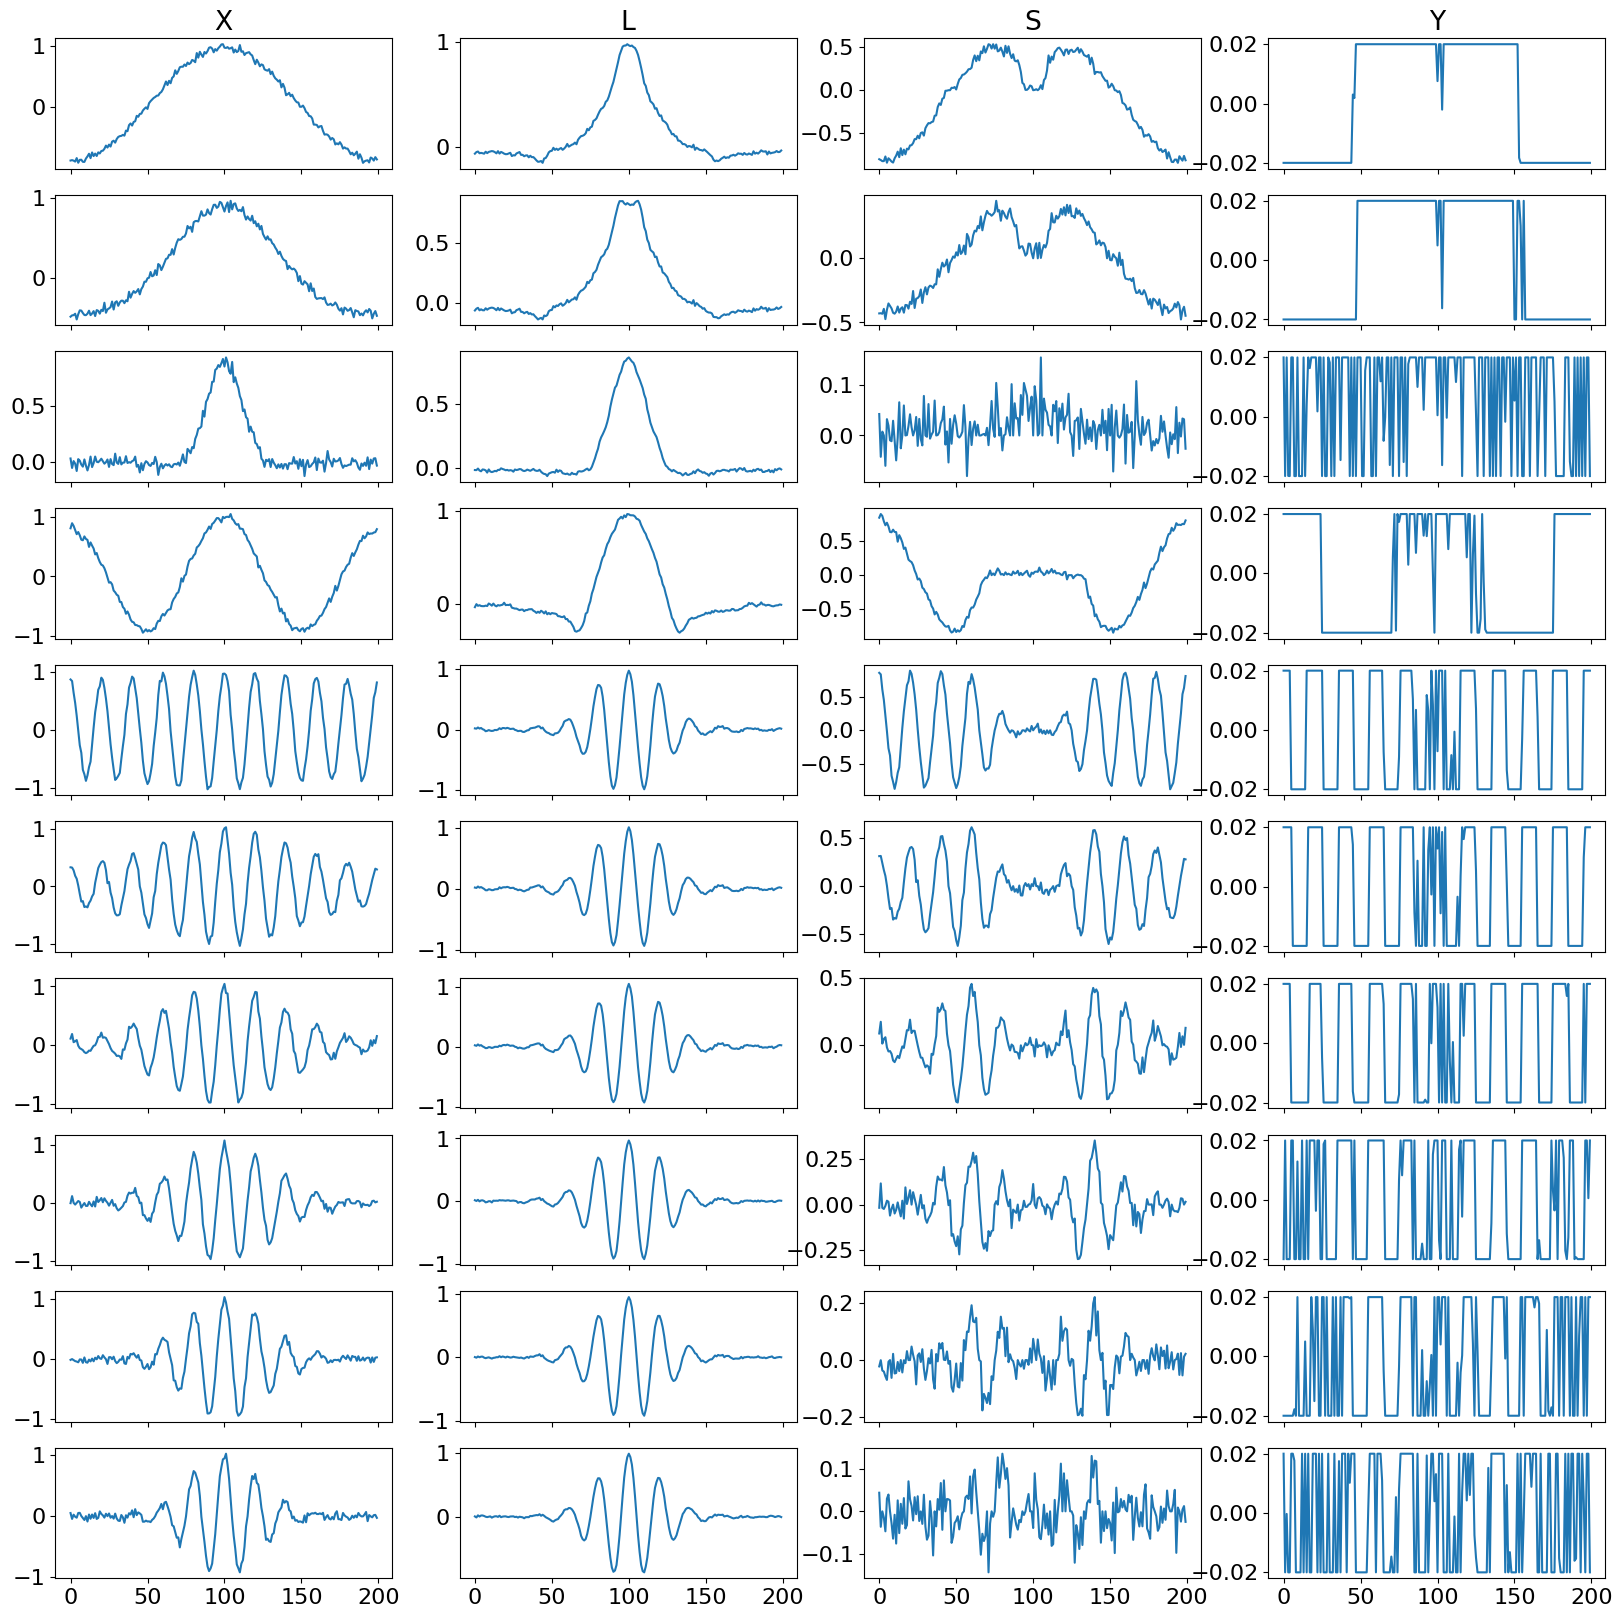

In [37]:
inds = np.arange(10) #np.random.randint(len(training_interferograms), size=10)

fig, axs = plt.subplots(len(inds), 4, figsize= (20, 2*len(inds)), sharex= True)

axs[0,0].set(title= "X")
axs[0,1].set(title= "L")
axs[0,2].set(title= "S")
axs[0,3].set(title= "Y")

for ax_row, k in zip(axs, inds):
    ax_row[0].plot(training_interferograms[k])

    ax_row[1].plot(components[k])

    ax_row[2].plot(sparse_errors[k])

    ax_row[3].plot(lagrange_multiplier[k])

plt.show()

In [14]:
Q, R, permutation_matrix = spla.qr(components, pivoting= True)

print("Permutation Matrix (P):")
print(permutation_matrix)

Permutation Matrix (P):
[100 104 108  88 116 120  76 128  68  94 136  60 144 149  47 158 163  33
 176 172  45 179 184  31  85 190 146   6   1 161  28 187 191  19  66   3
  90  48  24 122  40 168  35  12  57 171  62 166  23  81 198 185 157  37
 148 153  69 195  53  11  27 178  13 193  73 169  51 173  36   9  38   8
  25  61   5 170 181  46 160 141  65 197  44   4  50 180  18 199 129 119
  58  20 126 137 165  42 142 189 175   2  17  41  97  54  34 118  63   7
 121 159 155 135  99 101 112 107  98 102  95 103  91 105  89  96 106  92
  93 110 115 111 109  82  83 113  78 117  79  86 114 124  14  87  80  84
  77 154 123  74 188   0  67 125 132 127  70  72  75  55 130 143  71  39
 131 133  30 134 138 152  10 139 186 151  56  64  59 145 156 140  22  29
 177  16  52  15 167 164 147 150  26 174  49 192  32 182 194  43 162 196
 183  21]


In [15]:
interferogram_to_test = 11

test_file_name = "1dmockanderrors{0:d}".format(interferogram_to_test)

test_interferogram, test_uncertainties = cs.open_dataset(test_file_name, ".csv")

In [33]:
number_of_detectors = 8
regularization_coeffient = 1e-4

detectors = permutation_matrix[:number_of_detectors]

print(*np.sort(detectors), sep= ",")

76,88,100,104,108,116,120,128


In [34]:
samples = test_interferogram[detectors]
measurement_matrix = components[:,detectors]

lasso = Lasso(alpha= regularization_coeffient)
lasso.fit(measurement_matrix.T, samples)

result = np.matmul(components.T, lasso.coef_)

In [35]:
samples_with_gaps = np.full_like(test_interferogram, np.nan)
samples_with_gaps[detectors] = test_interferogram[detectors]
result2 = cs.compressed_sensing(samples_with_gaps, regularization_coeffient)

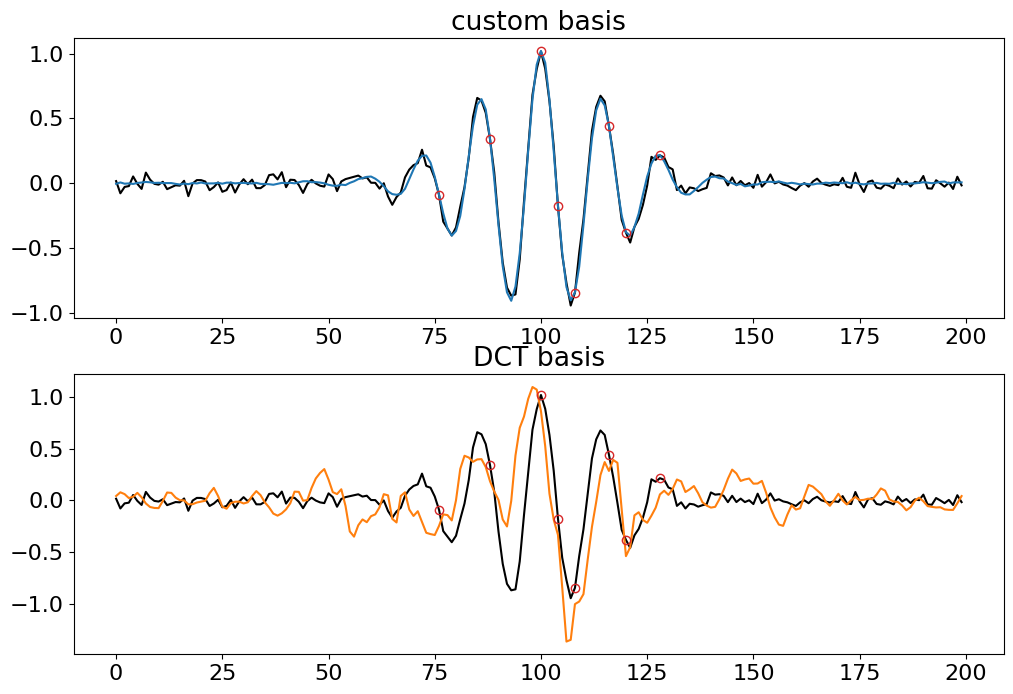

In [36]:
fig, axs = plt.subplots(2, 1, figsize= (12, 8))

axs[0].plot(test_interferogram, color= "k")
axs[0].plot(result, color= "tab:blue")
axs[0].plot(detectors, test_interferogram[detectors], color= "tab:red", marker= "o", linestyle= "none", markerfacecolor= "none")
axs[0].set(title= "custom basis")

axs[1].plot(test_interferogram, color= "k")
axs[1].plot(result2, color= "tab:orange")
axs[1].plot(detectors, test_interferogram[detectors], color= "tab:red", marker= "o", linestyle= "none", markerfacecolor= "none")
axs[1].set(title= "DCT basis")

plt.show()